In [20]:
from audiotools import AudioSignal

audio_fiile = 'airsound.wav'
asa = AudioSignal(audio_fiile).resample(44100)

print(asa.length/44100, " 초")
print(asa.audio_data.shape)
audio_data = asa.audio_data.squeeze()

device='cuda'

6.6735600907029475  초
torch.Size([1, 2, 294304])


In [1]:
# call VAE
from vae.get_function import create_autoencoder_from_config

auto_encoder_config = {
    'encoder': {
        'type': 'oobleck', # 현재는 oobleck 혹은 dac만 가능
        'requires_grad': False,
        'config': {
            'in_channels': 2,
            'channels': 128,
            'c_mults': [1, 2, 4, 8, 16],
            'strides': [2, 4, 4, 8, 8],
            'latent_dim': 128,
            'use_snake': True
        }
    },
    'decoder': {
        'type': 'oobleck',
        'requires_grad': False,
        'config': {
            'out_channels': 2,
            'channels': 128,
            'c_mults': [1, 2, 4, 8, 16],
            'strides': [2, 4, 4, 8, 8],
            'latent_dim': 64,
            'use_snake': True,
            'final_tanh': False
        }
    },
    'bottleneck': {'type': 'vae'},
    'latent_dim': 64,
    'downsampling_ratio': 2048,
    'io_channels': 2,
    'sample_rate': 44100
}

ae = create_autoencoder_from_config(auto_encoder_config)

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


latent :  torch.Size([1, 64, 143])
recon :  torch.Size([1, 2, 292864])



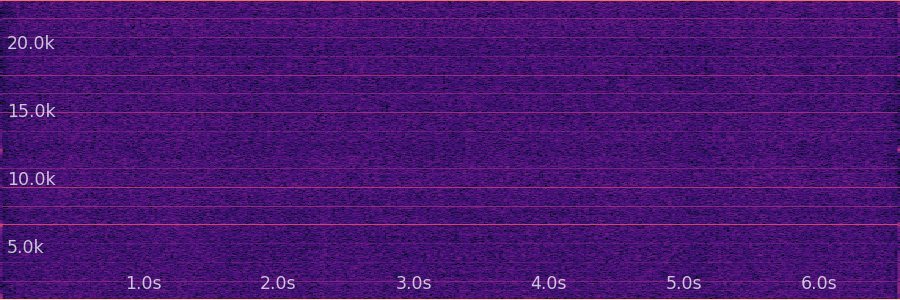
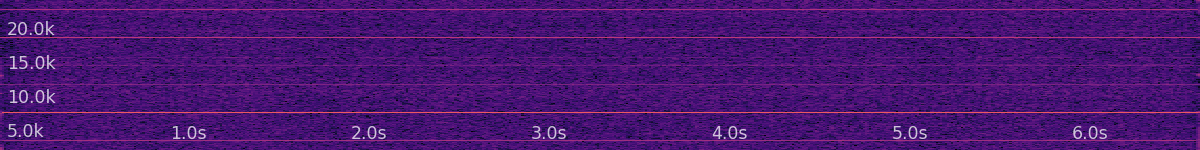

In [8]:
latent = ae.encode_audio(audio_data)
print("latent : ", latent.shape) # 21.5 Hz

audio_recon = ae.decode_audio(latent)
print("recon : ", audio_recon.shape)

print("Reconstruction")
AudioSignal(audio_recon.detach().numpy(), sample_rate=44100).widget()
print("Original audio")
asa.widget()

In [5]:
# call conditioner : text, duration seconds starts/end

from condition.conditioners import T5Conditioner
from condition.time_condition_model import NumberConditioner

text_conditioner_config = {"output_dim": 768, 't5_model_name': 't5-base', 'max_length': 128}
text_conditioner = T5Conditioner(**text_conditioner_config)

text_prompt = ['hello']

input_ids, attention_mask = text_conditioner(text_prompt, device=device)
print(input_ids.shape, attention_mask.shape)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [23]:
duration_config = {"output_dim": 768, 'min_val': 0, 'max_val': 512}

duration_start_conditioner = NumberConditioner(**duration_config).to(device)
duration_end_conditioner = NumberConditioner(**duration_config).to(device)

seconds_start = [0, 0]
seconds_end = [5, 5]

start_emb, _ = duration_start_conditioner(seconds_start, device=device)
end_emb, _ = duration_end_conditioner(seconds_end, device=device)

print(start_emb.shape)
print(end_emb.shape)

torch.Size([2, 1, 768])
torch.Size([2, 1, 768])


In [ ]:
# noise prediction model 선언

from noise.predictmodel import ContinuousTransformer